## Imports

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier 

murder = pd.read_csv('murder_project.csv')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing

In [ ]:
# Drop object with State being 'PAPSP8'
murder.drop(murder.loc[murder['State']=='PAPSP8'].index, inplace=True) 

# Drop objects with VicAge being 999
murder.drop(murder.loc[murder['VicAge']==999].index, inplace=True)

# Drop object with Relationship being undetermined
murder.drop(murder.loc[murder['Relationship']=='Relationship not determined'].index, inplace=True)

# Create dummy variables for every State object
states = [] 
for case in murder['State']:
  if case not in states:
    states.append(case)

def dummy_states(state):
    for entry in states:
        if state == entry:
            return states.index(entry)+1

murder['State'] = murder['State'].apply(dummy_states)

# Create dummy variables for every Homicide object
homicides = []
for case in murder['Homicide']:
  if case not in homicides:
    homicides.append(case)

for homicide in homicides:
    murder['Homicide'] =  murder['Homicide'].replace(homicide, homicides.index(homicide))

# Create dummy variables for every Situation object
situations = []
for case in murder['Situation']:
  if case not in situations:
    situations.append(case)

for situation in situations:
    murder['Situation'] =  murder['Situation'].replace(situation, situations.index(situation))

# Create dummy variables for every VicSex object
vic_sex = []
for case in murder['VicSex']:
  if case not in vic_sex:
    vic_sex.append(case)

for sex in vic_sex:
    murder['VicSex'] =  murder['VicSex'].replace(sex, vic_sex.index(sex))

# Create dummy variables for every VicRace object
vic_race = []
for case in murder['VicRace']:
  if case not in vic_race:
    vic_race.append(case)

for race in vic_race:
    murder['VicRace'] =  murder['VicRace'].replace(race, vic_race.index(race))

# Create dummy variables for every Weapon object
weapons = []
for case in murder['Weapon']:
  if case not in weapons:
    weapons.append(case)

for weapon in weapons:
    murder['Weapon'] =  murder['Weapon'].replace(weapon, weapons.index(weapon))

# Recategorizing classes
relations = []
for case in murder['Relationship']:
  if case not in relations:
    relations.append(case)

def recategorize_relations(relation):
    if relations.index(relation) in [1,3,8,10,12,21,27]:
      relation = 'Lover'
      return relation
    elif relations.index(relation) in [4,6,7,14,15,16,17,18,19,23,24,25]:
      relation = 'Family'
      return relation
    elif relations.index(relation) in [9,20]:
      relation = 'Ex-lover'
      return relation
    elif relations.index(relation) in [22,26]:
      relation = 'Employment'
      return relation
    elif relations.index(relation) in [0,13]:
      relation = 'Acquaintance'
      return relation
    else:
      return relation # 2: stranger, 5: friend, 11: neighbor

murder['Relationship'] = murder['Relationship'].apply(recategorize_relations)

# Create dummy variables for every Relationship object
relationships = []
for case in murder['Relationship']:
  if case not in relationships:
    relationships.append(case)

for relation in relationships:
    murder['Relationship'] =  murder['Relationship'].replace(relation, relationships.index(relation))

## Assigning variables

In [ ]:
feature_cols = ['State','Year', 'Incident','Homicide','Situation','VicAge', 'VicSex', 'VicRace', 'Weapon', 'VicCount']
X = murder[feature_cols] # Features
y = murder.Relationship # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

## The decision tree

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=13)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 
y_pred_proba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba,multi_class = "ovr")
print("AUC:", auc_score)

Accuracy: 0.5175707179054615
AUC: 0.7409796627251319


## ROC curve of decision tree

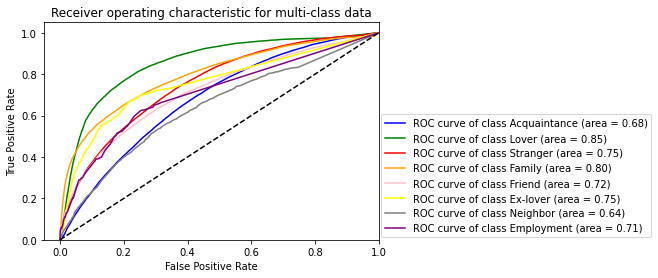

In [ ]:
# Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
classes = y_bin.shape[1]

# Split dataset into training set and test set
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=13)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred_bin = clf.predict(X_test)

# Wrap classifier
classifier = OneVsRestClassifier(clf)
y_pred_proba = classifier.fit(X_train, y_bin_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Construct ROC curve
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = itertools.cycle(['blue', 'green', 'red', 'orange', 'pink', 'yellow', 'grey', 'purple'])

for i, color in zip(range(classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(relationships[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(bbox_to_anchor=(0.99, 0.6))
plt.show()

## Random forest

In [ ]:
# Create Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=89, min_samples_split=2, random_state=0, max_depth=21)

# Train Random Forest Classifier
rf_clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_rf)))
y_pred_proba_rf = rf_clf.predict_proba(X_test)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class = "ovr")
print("AUC:", auc_rf)

Accuracy: 0.5302232288145162
AUC: 0.7699777005967219


## ROC curve of random forest

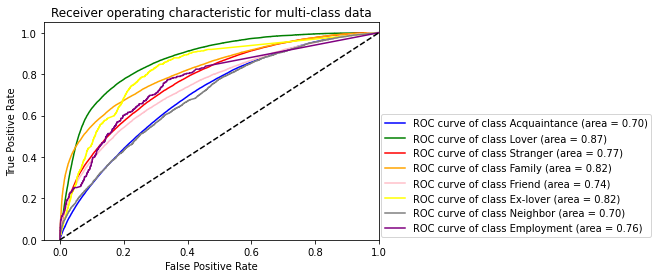

In [ ]:
# Reassign
y = murder.Relationship # Target variable

# Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
classes = y_bin.shape[1]

# Split dataset into training set and test set
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.3, random_state=1)

# Create Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=89, min_samples_split=2, random_state=0, max_depth=21)

# Train Random Forest Classifier
rf_clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

# Wrap classifier
classifier = OneVsRestClassifier(rf_clf)
y_pred_proba_rf = classifier.fit(X_train, y_bin_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Construct ROC curve
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = itertools.cycle(['blue', 'green', 'red', 'orange', 'pink', 'yellow', 'grey', 'purple'])

for i, color in zip(range(classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(relationships[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(bbox_to_anchor=(0.99, 0.6))
plt.show()

## Comparison ROC curve class 'Lover':                                                             decision tree vs. random forest

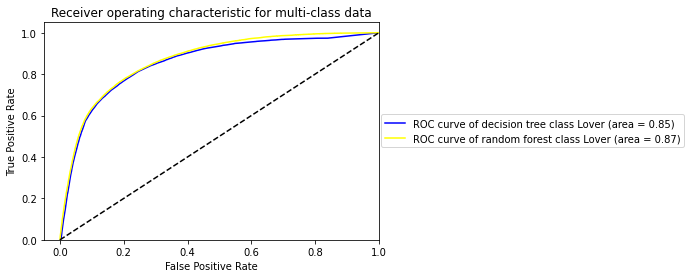

In [ ]:

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=13)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Wrap classifier
classifier = OneVsRestClassifier(clf)
y_pred_proba = classifier.fit(X_train, y_bin_train).predict_proba(X_test)

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

# Create Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=89, min_samples_split=2, random_state=0, max_depth=21)

# Train Random Forest Classifier
rf_clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

# Wrap classifier
classifier2 = OneVsRestClassifier(rf_clf)
y_pred_proba_rf = classifier2.fit(X_train, y_bin_train).predict_proba(X_test)

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()

# Construct ROC curve for decision tree 
for i in range(classes):
    fpr1[i], tpr1[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba[:, i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

# Construct ROC curve for random forest
for i in range(classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba_rf[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

plt.plot(fpr1[1], tpr1[1], color='blue',label='ROC curve of decision tree class {0} (area = {1:0.2f})'.format(relationships[1], roc_auc1[1]))
plt.plot(fpr2[1], tpr2[1], color='yellow',label='ROC curve of random forest class {0} (area = {1:0.2f})'.format(relationships[1], roc_auc2[1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(bbox_to_anchor=(0.99, 0.6))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=561f8f84-2db1-4718-81d9-bad66d02bc44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>